In [1]:
import datetime
import logging
import os
import glob 
from datetime import datetime, timedelta
import re

from pathlib import Path
from osgeo import gdal, osr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from pyproj import Transformer
from sklearn.metrics import cohen_kappa_score
from shapely.geometry import LinearRing, Point, Polygon, box
import rasterio
import requests
from pprint import pprint


In [2]:
def gdal_load(path, band):
    """
    Load image file into array
    using gdal.
    
    Inputs
    ------
    path = path to image file, text.
    band = band to load, int.
    
    Returns
    -------
    loaded file as numpy array
    """
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    arr = ds.GetRasterBand(band).ReadAsArray()
    #length, width = ds.RasterYSize, ds.RasterXSize
    # We also save the raster geo info to use them for plotting later 
    # ulx, uly stands for upper left corner, lrx, lry for lower right corner
    ulx, xres, xskew, uly, yskew, yres  = ds.GetGeoTransform()
    x = ulx + np.arange(ds.RasterXSize, dtype=float) * xres
    y = uly + np.arange(ds.RasterYSize, dtype=float) * yres
    # this empties the gdal raster variable that we no longer need since the raster has been saved into and array
    ds = None 
    
    return arr, x, y


In [3]:
def extract_datetime(filename):
    """
    Extract a datetime string in the format '_YYYYMMDDTHHMMSSZ' from the filename.

    Parameters
    ----------
    filename : str
        Filename containing the date/time.

    Returns
    -------
    datetime.datetime or None
        Parsed datetime object or None if not found.
    """
    #match = re.search(r'(\d{8}T\d{6}Z)', filename)  # Get start date
    match = re.search(r'_(\d{8}T\d{6}Z)', filename)  # Get end date
    if match:
        #return datetime.strptime(match.group(), "%Y%m%dT%H%M%SZ")  # Start date to datetime object
        return datetime.strptime(match.group(1), "%Y%m%dT%H%M%SZ")  # End date to datetime object
    return None

def load_data_stack(download_folder, data_type, start_datetime, end_datetime):
    """
    Load and stack WTR data for all files in a date range.

    Parameters
    ----------
    download_folder : str
        Folder path containing WTR GeoTIFF files.
    data_type : str
        'HLS' or 'S1' type used for file filtering.
    start_datetime : datetime
        Start of time range.
    end_datetime : datetime
        End of time range.

    Returns
    -------
    data_WTR : np.ndarray
        Stacked 3D array (rows x cols x time).
    """
    # Find matching WTR files
    files_WTR = sorted(glob.glob(download_folder + f"/*-{data_type}_*_WTR.tif"))
    print(f"# {data_type} WTR: {len(files_WTR)}")
    
    data_stack = []

    for fp in files_WTR:
        date_fp = extract_datetime(fp)  # Extract timestamp from filename
        if date_fp < start_datetime:
            continue  # Skip files outside the date range
        if date_fp > end_datetime:
            continue  # Skip files outside the date range

        data, x, y = gdal_load(fp, 1)
        data_stack.append(data)

    data_WTR = np.stack(data_stack, axis = -1) # stack of all historical HLS data

    return data_WTR, x, y

def generate_occurrence_map(data, target_value=1):
    """
    Generate an occurrence probability map for a specific class value (default is water=1),
    excluding cloud (253) and no-data (255) pixels.

    Parameters
    ----------
    data : numpy.ndarray
        A 3D numpy array (height x width x time).
    target_value : int, optional
        The value whose occurrence probability is to be computed (default is 1 for open water).

    Returns
    -------
    occurrence_map : numpy.ndarray
        A 2D array with occurrence probabilities (float in [0,1]).
    """
    # Define valid pixels: exclude cloud (253) and nonvalid (255)
    valid_mask = (data != 253) & (data != 255)

    # Count how many times target_value appears in valid observations
    count_target = np.sum((data == target_value) & valid_mask, axis=-1)

    # Count total number of valid observations
    count_valid = np.sum(valid_mask, axis=-1)

    # Compute probability while avoiding divide-by-zero
    occurrence_map = np.divide(
        count_target, count_valid,
        where=(count_valid > 0),
        out=np.full(count_target.shape, np.nan, dtype=float)
    )

    return occurrence_map

def generate_water_occurrence_map(data):
    """
    Generate a water occurrence map for the 3D array excluding invalid data.

    Parameters
    ----------
    data : np.ndarray
        3D array (height x width x time) of WTR labels.

    Returns
    -------
    water_occurrence_map : np.ndarray
        2D array showing fraction of valid observations that were water.
    """
    # Mask to exclude cloud(253) and nonvalid(255) pixels
    valid_mask = (data != 253) & (data != 255)

    # Count the occurrences of open water(1) and valid (non-255) observations for each pixel
    count_ones = np.sum((data == 1) & valid_mask, axis=-1)
    
    # Count number of valid observations
    count_valid = np.sum(valid_mask, axis=-1)

    # Compute ratio of water presence, avoiding division by zero
    water_occurrence_map = np.divide(
        count_ones, count_valid, where=(count_valid > 0), 
        out=np.full(count_ones.shape, np.nan, dtype=float)
    )

    return water_occurrence_map


Manage EarthData Credential

- create .netrc file<br>
$ nano ~/.netrc

- Add your EarthData login credentials in the following format:<br>
machine urs.earthdata.nasa.gov<br>
login your_username<br>
password your_password

- Save and exit<br>
Ctrl + X, Y, Enter

- Set file permissions<br>
chmod 600 ~/.netrc




In [7]:
def download_dswx(polys, 
                      datetime_start_str, 
                      datetime_end_str, 
                      MGRS_tile,
                      data_type,
                      download_dir,
                      download_flag=True):
    """
    Query and download DSWx files from NASA CMR, then create a water occurrence map.

    Parameters
    ----------
    polys : shapely Polygon or box
        Area of interest for bounding box.
    datetime_start_str : str
        ISO string of start datetime.
    datetime_end_str : str
        ISO string of end datetime.
    MGRS_tile : str
        Tile ID to filter files.
    data_type : str
        Either 'HLS' or 'S1'.
    download_dir : str
        Folder to store downloaded data.
    download_flag : bool
        Whether to download files or just simulate.

    Returns
    -------
    water_occurrence_map : np.ndarray
        Resulting water probability map.
    """
    CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'  # NASA's Common Metadata Repository endpoint
    url = f'{CMR_OPS}/{"granules"}'  # Search endpoint
    boundind_box = polys.bounds
    provider = 'POCLOUD'

    # Parse date strings into datetime objects
    start_datetime = datetime.strptime(datetime_start_str, "%Y-%m-%dT%H:%M:%SZ")
    end_datetime = datetime.strptime(datetime_end_str, "%Y-%m-%dT%H:%M:%SZ")

    # Set collection ID for desired dataset
    if data_type == 'HLS':
        concept_id = 'C2617126679-POCLOUD'
    if data_type == 'S1':
        concept_id = 'C2949811996-POCLOUD'

    # Prepare output folder
    download_folder = download_dir + 'download_' + mgrs_tile + '_water_occurrence'
    os.makedirs(download_folder, exist_ok = True)

    # iterate for 30 days intervals
    current_start = start_datetime
    while current_start < end_datetime:
        # Calculate the end of the current month interval
        current_end = min (current_start + timedelta(days = 30), end_datetime)
        print(current_start)
        print(current_end)

        parameters = {
            'temporal': f'{current_start.strftime("%Y-%m-%dT%H:%M:%SZ")},{current_end.strftime("%Y-%m-%dT%H:%M:%SZ")}',
            'concept_id': concept_id,
            'provider': provider,
            'bounding_box': f'{boundind_box[1]},{boundind_box[0]},{boundind_box[3]},{boundind_box[2]}',
            'page_size': 2000,
            }
        print(parameters)
        response = requests.get(url,
            params=parameters,
            headers={'Accept': 'application/json'}
            )
        print(response.status_code)
        print(response.headers['CMR-Hits'])

        downloaded_list = []
        num_search_data = response.headers['CMR-Hits']
        number_data = 0
        if num_search_data:
            collections = response.json()['feed']['entry']
            for collection in collections:
                dswx_hls_file_id = collection['producer_granule_id']
                if MGRS_tile not in dswx_hls_file_id:
                    print('MGRS tile id does not match')
                    continue
                    
                print('url', f'{collection["links"][4]["href"]}')
                print('s3', f'{collection["links"][3]["href"]}')
                if download_flag:
                    for layer in range(12):#[0, 2, 4, 6, 8, 10]:  # 2: WTR, 4: BWTR, 6:CONF (not always)
                        dswx_hls_url = collection["links"][layer]["href"]
                        dswx_hls_filename = os.path.basename(dswx_hls_url)

                        # Filter to only specific layers (STR, BWTR, CONF)
                        if not any(substring in dswx_hls_filename for substring in ['_B01_WTR.tif', '_B02_BWTR.tif', '_B03_CONF.tif']): # B01: WTR, B02: BWTR, B03: CONF
                            continue
                        if any(substring in dswx_hls_filename for substring in ['.md5']):
                            continue
                            
                        download_file = f'{download_folder}/{dswx_hls_filename}'

                        if not os.path.isfile(download_file):
                            response = requests.get(dswx_hls_url, stream=True)

                        # Check if the request was successful
                            if response.status_code == 200:
                                # Open a local file with wb (write binary) permission.
                                with open(f'{download_file}', 'wb') as file:
                                    print('downloading')
                                    for chunk in response.iter_content(chunk_size=128):
                                        file.write(chunk)
                else:
                    print('under dev.')
                downloaded_list.append(download_file)
                number_data += 1
        
        current_start = current_end  # Move to next interval

    # Load raster stack and compute water probability
    data_stack, x, y = load_data_stack(download_folder, data_type, start_datetime, end_datetime)
    water_occurrence_map = generate_occurrence_map(data_stack)

    return water_occurrence_map, x, y

2023-04-01 00:00:00
2023-05-01 00:00:00
{'temporal': '2023-04-01T00:00:00Z,2023-05-01T00:00:00Z', 'concept_id': 'C2617126679-POCLOUD', 'provider': 'POCLOUD', 'bounding_box': '-124.4,36.9,-120.6,39.9', 'page_size': 2000}
200
224
MGRS tile id does not match
MGRS tile id does not match
MGRS tile id does not match
MGRS tile id does not match
MGRS tile id does not match
MGRS tile id does not match
MGRS tile id does not match
url https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T10SFH_20230409T184921Z_20230411T182938Z_S2A_30_v1.0_B02_BWTR.tif
s3 s3://podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T10SFH_20230409T184921Z_20230411T182938Z_S2A_30_v1.0_B01_WTR.tif
downloading
downloading
downloading
MGRS tile id does not match
MGRS tile id does not match
MGRS tile id does not match
MGRS tile id does not match
MGRS tile id does not match
MGRS tile id does not match
MGRS tile id does not match

/u/aurora-r0/jeon/tools/anaconda3/envs/dswx-env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


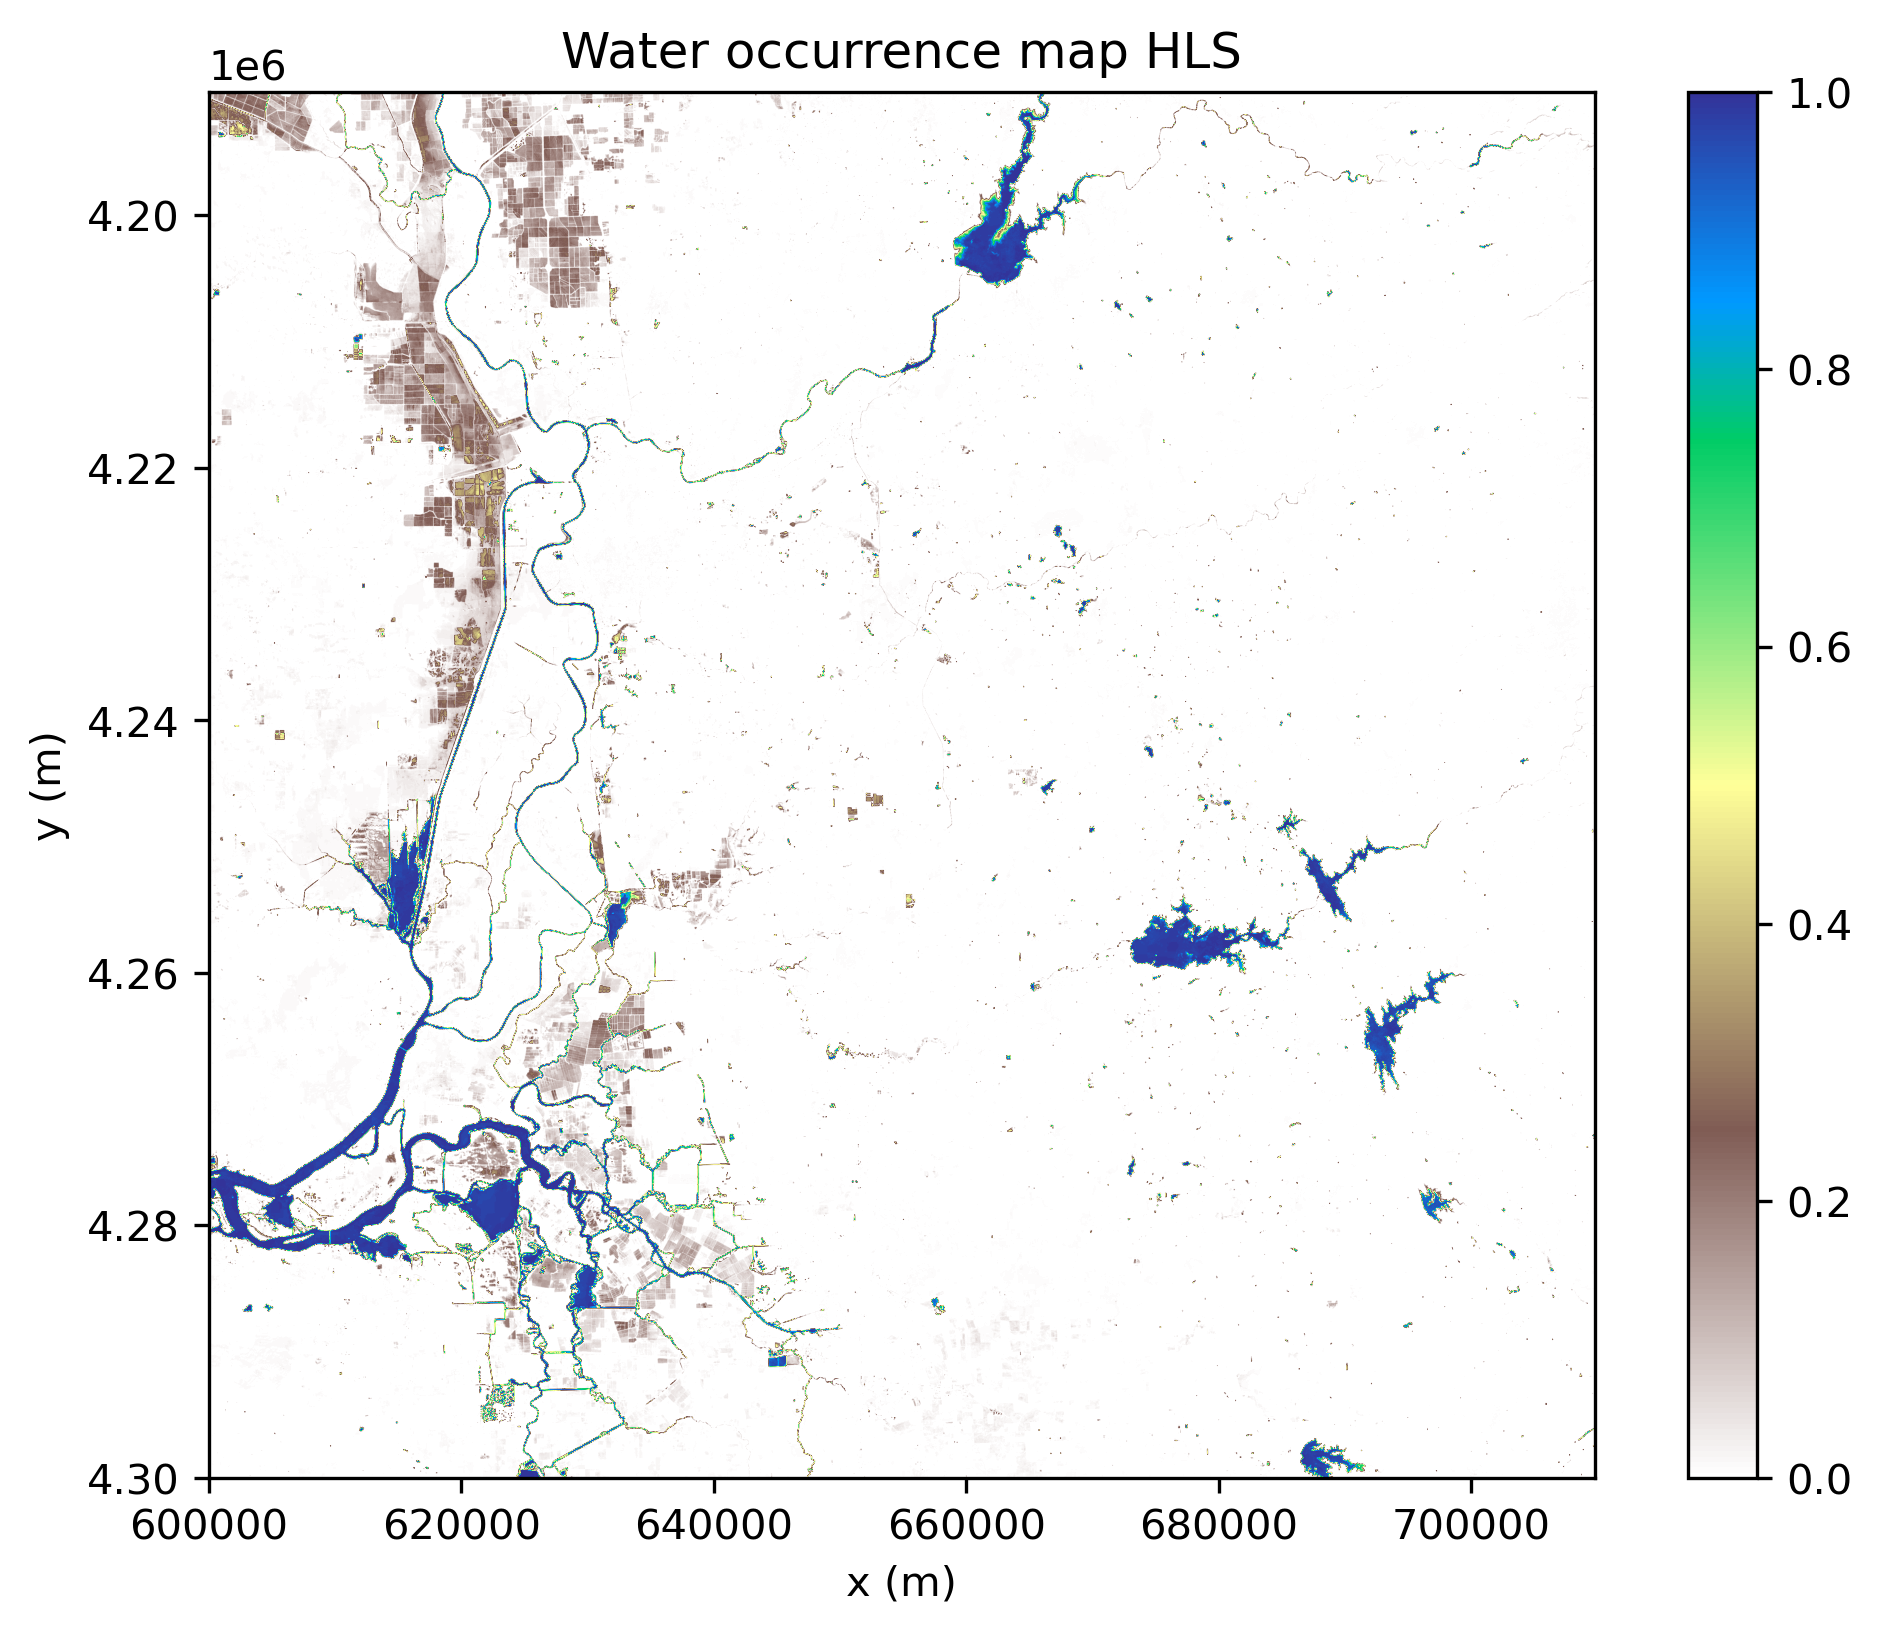

In [8]:
# ========== EXAMPLE USAGE ==========
# Define bounding box polygon for region of interest
poly_cand = box(36.9,-124.4,  39.9,-120.6) #10S
#poly_cand = box(33.38,-119.26,  35.3,-115.83) #11S

# Date range for querying granules
datetime_start_str = '2023-04-01T00:00:00Z'
datetime_end_str = '2024-12-31T00:00:00Z'

# Local directory to save downloaded files
download_dir = ''  #'/u/aurora-r0/jeon/tools/DSWx-fusion/DSWx-Enhanced-Analysis/'

# Dataset type and tile ID
data_type = 'HLS'
#mgrs_tile = '11SLU'
mgrs_tile = '10SFH'

# Run full download and analysis pipeline
water_occurrence_map, x, y = download_dswx(poly_cand, datetime_start_str, datetime_end_str, mgrs_tile, data_type, download_dir)  

# Plot the resulting water occurrence probability map
im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(water_occurrence_map, cmap='terrain_r', extent=[x[0], x[-1], y[0], y[-1]]) 
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Water occurrence map HLS')
plt.colorbar()

2023-04-01 00:00:00
2023-05-01 00:00:00
{'temporal': '2023-04-01T00:00:00Z,2023-05-01T00:00:00Z', 'concept_id': 'C2949811996-POCLOUD', 'provider': 'POCLOUD', 'bounding_box': '-124.4,36.9,-120.6,39.9', 'page_size': 2000}
200
0
2023-05-01 00:00:00
2023-05-31 00:00:00
{'temporal': '2023-05-01T00:00:00Z,2023-05-31T00:00:00Z', 'concept_id': 'C2949811996-POCLOUD', 'provider': 'POCLOUD', 'bounding_box': '-124.4,36.9,-120.6,39.9', 'page_size': 2000}
200
0
2023-05-31 00:00:00
2023-06-30 00:00:00
{'temporal': '2023-05-31T00:00:00Z,2023-06-30T00:00:00Z', 'concept_id': 'C2949811996-POCLOUD', 'provider': 'POCLOUD', 'bounding_box': '-124.4,36.9,-120.6,39.9', 'page_size': 2000}
200
0
2023-06-30 00:00:00
2023-07-30 00:00:00
{'temporal': '2023-06-30T00:00:00Z,2023-07-30T00:00:00Z', 'concept_id': 'C2949811996-POCLOUD', 'provider': 'POCLOUD', 'bounding_box': '-124.4,36.9,-120.6,39.9', 'page_size': 2000}
200
0
2023-07-30 00:00:00
2023-08-29 00:00:00
{'temporal': '2023-07-30T00:00:00Z,2023-08-29T00:00:00Z'

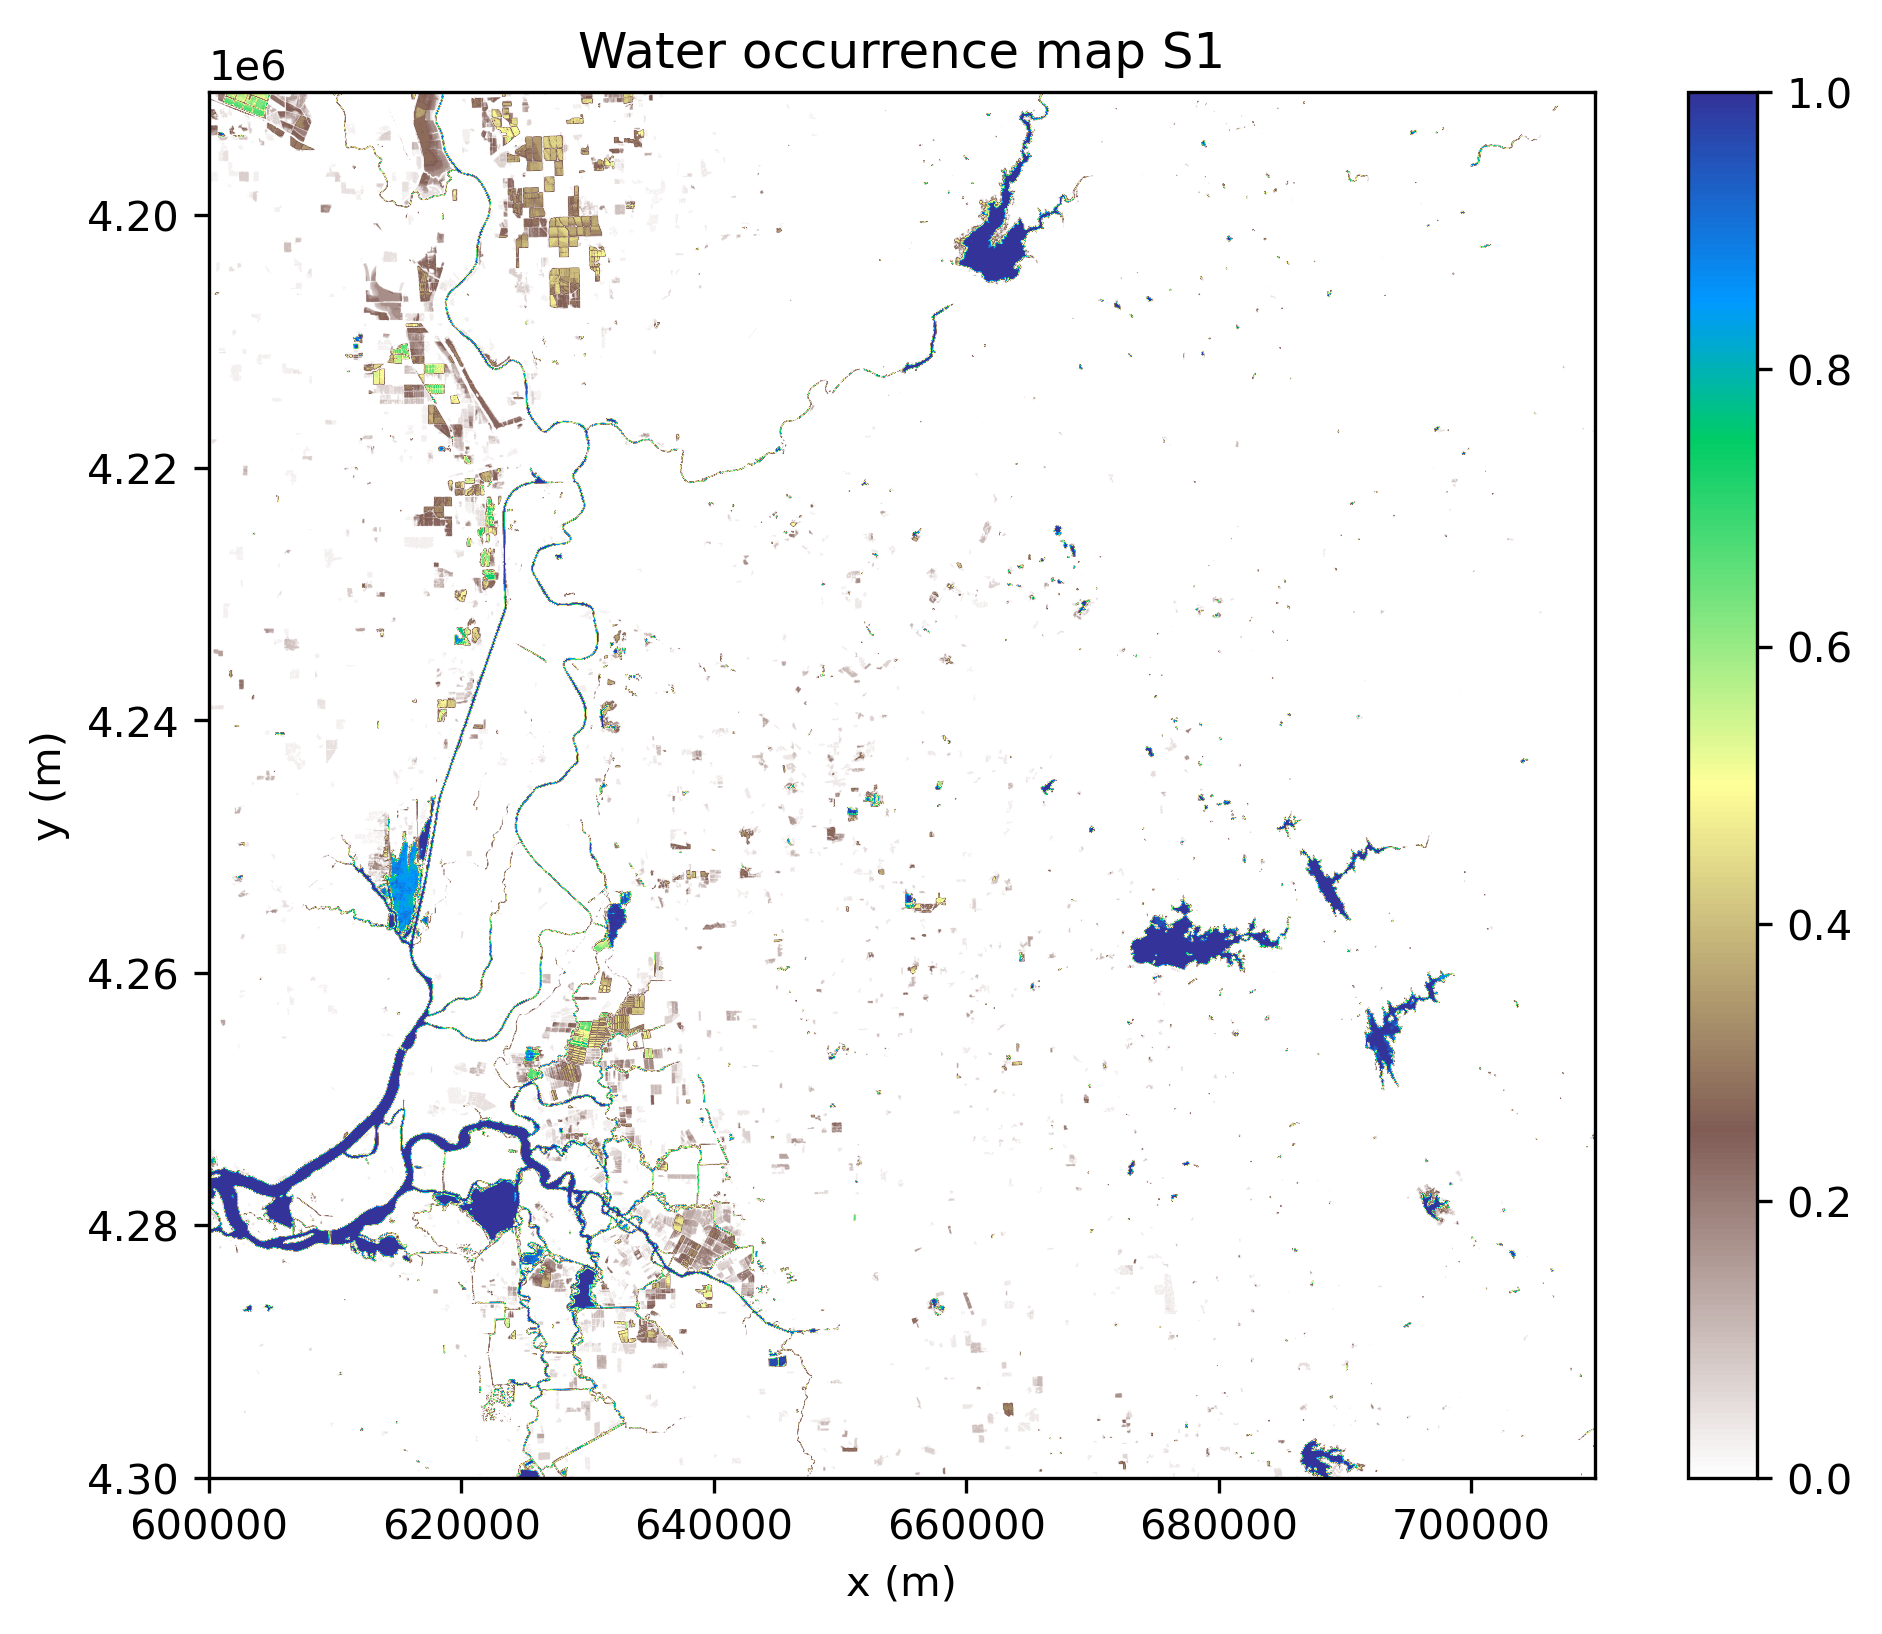

In [9]:
# Dataset type and tile ID
data_type = 'S1'

# Run full download and analysis pipeline
water_occurrence_map, x, y = download_dswx(poly_cand, datetime_start_str, datetime_end_str, mgrs_tile, data_type, download_dir)  

# Plot the resulting water occurrence probability map
im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(water_occurrence_map, cmap='terrain_r', extent=[x[0], x[-1], y[0], y[-1]]) 
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Water occurrence map S1')
plt.colorbar()